In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math 
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import datetime


#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

import os
import xgboost as xgb

#train, test, cv splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score,confusion_matrix

#dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

#hyperparameter tuning
from bayes_opt import BayesianOptimization

#nlp
from pymystem3 import Mystem
import nltk 
from nltk.corpus import stopwords 

#showing all rows and cols without ...
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 400
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [ ]:
nltk.download()

### Transliterating region and city: chaning from cyrillic alphabet to Latin alphabet
https://programminghistorian.org/lessons/transliterating

In [ ]:
def Transliterate(word):
    cyrillic_translit={u'\u0410': 'A', u'\u0430': 'a',
                       u'\u0411': 'B', u'\u0431': 'b',
                        u'\u0412': 'V', u'\u0432': 'v',
                        u'\u0413': 'G', u'\u0433': 'g',
                        u'\u0414': 'D', u'\u0434': 'd',
                        u'\u0415': 'E', u'\u0435': 'e',
                        u'\u0416': 'Zh', u'\u0436': 'zh',
                        u'\u0417': 'Z', u'\u0437': 'z',
                        u'\u0418': 'I', u'\u0438': 'i',
                        u'\u0419': 'I', u'\u0439': 'i',
                        u'\u041a': 'K', u'\u043a': 'k',
                        u'\u041b': 'L', u'\u043b': 'l',
                        u'\u041c': 'M', u'\u043c': 'm',
                        u'\u041d': 'N', u'\u043d': 'n',
                        u'\u041e': 'O', u'\u043e': 'o',
                        u'\u041f': 'P', u'\u043f': 'p',
                        u'\u0420': 'R', u'\u0440': 'r',
                        u'\u0421': 'S', u'\u0441': 's',
                        u'\u0422': 'T', u'\u0442': 't',
                        u'\u0423': 'U', u'\u0443': 'u',
                        u'\u0424': 'F', u'\u0444': 'f',
                        u'\u0425': 'Kh', u'\u0445': 'kh',
                        u'\u0426': 'Ts', u'\u0446': 'ts',
                        u'\u0427': 'Ch', u'\u0447': 'ch',
                        u'\u0428': 'Sh', u'\u0448': 'sh',
                        u'\u0429': 'Shch', u'\u0449': 'shch',
                        u'\u042a': '"', u'\u044a': '"',
                        u'\u042b': 'Y', u'\u044b': 'y',
                        u'\u042c': "'", u'\u044c': "'",
                        u'\u042d': 'E', u'\u044d': 'e',
                        u'\u042e': 'Iu', u'\u044e': 'iu',
                        u'\u042f': 'Ia', u'\u044f': 'ia'}
    converted_word = ''
    for char in word:
        transchar = ''
        if char in cyrillic_translit:
            transchar = cyrillic_translit[char]
        else:
            transchar = char
        converted_word += transchar
    return converted_word

In [ ]:
def CheckDistribution(y_train):
    sns.distplot(y_train, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(y_train)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('SalePrice distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(y_train, plot=plt)
    plt.show()
    

In [10]:
def PreProcess(train):
    train['HasImage'] = 0
    train.loc[train.image.notnull(),'HasImage']=1
    train.drop('item_id',axis=1, inplace=True)

    #adding features
    cols = ['param_1', 'param_2', 'param_3','title','description']
    for col in cols:
        train[col+'_len'] = train[col].str.decode('utf-8').str.len()
    train['title_numb_of_words'] = train['title'].str.count(' ').add(1)
    train['description_numb_of_words'] = train['description'].str.count(' ').add(1)

    train.activation_date = pd.to_datetime(train.activation_date, errors='coerce')
    train['Day'] = train['activation_date'].dt.day
    train['Month_beg']=0
    train.loc[train.Day < 15, 'Month_beg'] = 1

    train.loc[train.parent_category_name=='Личные вещи','parent_category_name'] = train.loc[train.parent_category_name=='Lichnye veshchi','category_name']

    train= pd.get_dummies(train, columns=['user_type','parent_category_name'])
        
    train["activation_weekday"] = train["activation_date"].dt.weekday

    train.drop('region', axis=1, inplace=True)
    train.drop('city', axis=1, inplace=True)
    train.drop('category_name', axis=1, inplace=True)

    train.drop('param_1', axis=1, inplace=True)
    train.drop('param_2', axis=1, inplace=True)
    train.drop('param_3', axis=1, inplace=True)
    train.drop('activation_date', axis=1, inplace=True)
    train.drop('Day', axis=1, inplace=True)
    train.drop('user_id', axis=1, inplace=True)
    train.drop('title', axis=1, inplace=True)
    train.drop('description', axis=1, inplace=True)
    train.drop('image', axis=1, inplace=True)
    
    return train



In [ ]:
def Explore(train):
    print len(train), len(train.columns)
#     print "Number of users: " + str(len(train.user_id.unique()))
    print "Number of regions: " + str(len(train.region.unique()))
    print "Number of cities: " + str(len(train.city.unique()))
#     print "Number of parent categories: " + str(len(train.parent_category_name.unique()))
    print "Number of categories: " + str(len(train.category_name.unique()))
    print "Number of param1: " + str(len(train.param_1.unique()))
    print "Number of param2: " + str(len(train.param_2.unique()))
    print "Number of param3: " + str(len(train.param_3.unique()))
#     print "with image: " + str(len(train.loc[train.image.notnull()]))
#     print "without image: " + str(len(train.loc[train.image.isnull()]))
#     print "with image deal prob mean: " + str(train.loc[train.image.notnull()].deal_probability.mean())
#     print "without image: " + str(train.loc[train.image.isnull()].deal_probability.mean())
#     print train.parent_category_name.unique()
#     CheckDistribution(train.deal_probability)
#     print train.param_3.value_counts()
#     print train.groupby(['param_3']).deal_probability.mean()

#     print test.loc[test.parent_category_name=='Lichnye veshchi'].category_name.value_counts()
#     print test.loc[test.parent_category_name=='Lichnye veshchi'].groupby(['category_name']).deal_probability.mean()
    
#     plt.scatter(train.parent_category_name.value_counts(), train.groupby(['parent_category_name']).deal_probability.mean())

    plt.scatter(np.unique(train.Day),train.Day.value_counts())
    plt.show()

In [ ]:
def xgb_rmse(preds, dtrain):
    # Courtesy of Tilii
    labels = dtrain.get_label()
    return 'rmse', math.sqrt(mean_squared_error(labels, preds))

In [ ]:
def train_xgb(max_depth, subsample, min_child_weight, gamma, colsample_bytree):
    # Evaluate an XGBoost model using given params
    xgb_params = {
        'n_trees': 250,
        'eta': 0.01,
        'max_depth': int(max_depth),
        'subsample': max(min(subsample, 1), 0),
        'objective': 'reg:linear',
        'base_score': np.mean(Y), # base prediction = mean(target)
        'silent': 1,
        'min_child_weight': int(min_child_weight),
        'gamma': max(gamma, 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }
    scores = xgb.cv( xgb_params, dtrain, num_boost_round=1500,early_stopping_rounds=20, feval=xgb_rmse,verbose_eval=False, maximize=True, nfold=10)['test-rmse-mean'].iloc[-1]
    return scores

In [23]:
%%time
train_raw = pd.read_csv("Data/train.csv")
test_raw = pd.read_csv("Data/test.csv")

CPU times: user 20.1 s, sys: 8.27 s, total: 28.4 s
Wall time: 37 s


In [24]:
%%time
y = train_raw.deal_probability 
train_raw.drop('deal_probability', axis=1, inplace=True)

combined = train_raw.append(test_raw)
combined = PreProcess(combined)

CPU times: user 33.7 s, sys: 5.57 s, total: 39.3 s
Wall time: 40.5 s


In [25]:
train = combined[:len(train_raw)]
test = combined[len(train_raw):]

In [29]:
train_all_data = pd.read_csv("Data/train.csv")
# train_all_data.loc[train_all_data.deal_probability==0,['title','price','description']].head(100)

In [30]:
# train_all_data.parent_category_name.value_counts()
# train_all_data.groupby('parent_category_name')['deal_probability'].mean()

SyntaxError: invalid syntax (<ipython-input-30-f6ecadc32287>, line 2)

# for now let's just make all nan 0

In [ ]:
what if we replace categorical vars with group deal_probability

In [26]:
combined.fillna(0,inplace=True)

In [ ]:
test.head()

In [ ]:
combined.shape

In [33]:
train.loc[train.Day]

0

In [ ]:
len(train)

In [ ]:
train.head()

In [ ]:
test.head()

#### A Python wrapper of the Yandex Mystem 3.0 morphological analyzer
https://github.com/nlpub/pymystem3
Get russian stopwords from nltk.
<code>from nltk.corpus import stopwords 
stop = set(stopwords.words('russian'))</code>



In [ ]:
# Explore(train)
Explore(test)

In [ ]:
text = "Красивая мама красиво мыла раму"
m = Mystem()
lemmas = m.lemmatize(text)
print(''.join(lemmas))

In [ ]:
stop = set(stopwords.words('russian'))

In [ ]:
for s in stop:
    print s

In [15]:
#let's divide the train set into train and cv
X_train,X_cv, y_train, y_cv = train_test_split(train, y, test_size = 0.2, random_state = 43)

In [27]:
scores_rf = cross_val_score(clf_rf,train, y, cv=5, scoring='mean_squared_error')
score_rf= np.sqrt(-scores_rf).mean()
print score_rf
# y_rf_cv = cross_val_predict(clf_rf, train, y, cv=10, scoring='mean_squared_error')

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/b

0.230921083704


In [ ]:
scores_ada= cross_val_score(clf_ada,train, y, cv=10, scoring='mean_squared_error')
score_ada = np.sqrt(-scores_ada).mean()
print score_ada

In [ ]:
scores_bag= cross_val_score(clf_bag,train, y, cv=10, scoring='mean_squared_error')
score_bag = np.sqrt(-scores_bag).mean()
print score_bag

In [ ]:
scores_gb= cross_val_score(clf_gb,train, y, cv=10, scoring='mean_squared_error')
score_gb = np.sqrt(-scores_gb).mean()
print score_gb

In [ ]:
scores_xgb= cross_val_score(clf_xgb,train, y, cv=10, scoring='mean_squared_error')
score_xgb = np.sqrt(-scores_xgb).mean()
print score_xgb

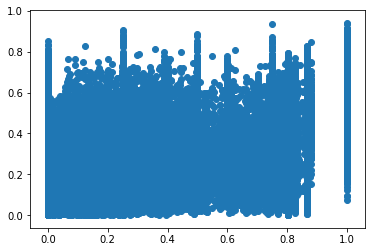

0.213426447156 0.231024382877


In [16]:
# Random Forest
clf_rf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=6,random_state=43)
clf_rf.fit(X_train, y_train)
score_rf = clf_rf.score(X_cv, y_cv)
y_cv_predict = clf_rf.predict(X_cv)

plt.scatter(y_cv, y_cv_predict)
plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_rf_test = clf_rf.predict(test)

In [17]:
#AdaBoost
clf_ada = AdaBoostRegressor(random_state=43)
clf_ada.fit(X_train, y_train)
y_cv_predict = clf_ada.predict(X_cv)
# plt.scatter(y_cv, y_cv_predict)
# plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_ada_test = clf_ada.predict(test)


0.0405622444386 0.255150574895


In [18]:
#bagging 
clf_bag = BaggingRegressor(random_state=43)
clf_bag.fit(X_train , y_train )
y_cv_predict = clf_bag.predict(X_cv)
# plt.scatter(y_cv, y_cv_predict)
# plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_bag_test = clf_bag.predict(test)


0.133380053225 0.242494833024


In [19]:
#gb  
clf_gb = GradientBoostingRegressor(random_state=43)
clf_gb.fit(X_train , y_train )
y_cv_predict = clf_gb.predict(X_cv)
# plt.scatter(y_cv, y_cv_predict)
# plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_gb_test = clf_gb.predict(test)


0.167754437538 0.237636907995


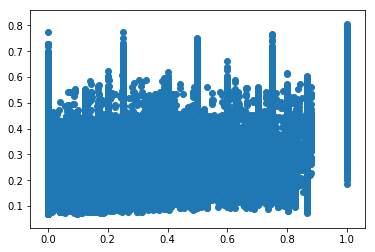

0.156097220025 0.239295404081


In [20]:
#xgb
clf_xgb = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.01, subsample= 0.72594007111201053, 
                           colsample_bytree=0.99039137352867346, 
                           min_child_weight= 10.569011344756881,
                           gamma=0.27084988920089037, max_depth= 10)

clf_xgb.fit(X_train, y_train)
y_cv_predict = clf_xgb.predict(X_cv)
plt.scatter(y_cv, y_cv_predict)
plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_xgb_test = clf_xgb.predict(test)


Finding optimal parameters for xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
Y = y_train
params = {
  'min_child_weight':(1, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 10)
}                            
# Initialize BO optimizer
xgb_bayesopt = BayesianOptimization(train_xgb, params)

# Maximize rmse score
xgb_bayesopt.maximize(init_points=5, n_iter=25)

# Get the best params
p = xgb_bayesopt.res['max']['max_params']

print p

In [ ]:
file_numb = 1

In [ ]:
file_numb = file_numb+1
with open('submission_'+str(file_numb)+'.csv', "w") as out:
    out.write("item_id,deal_probability\n")
    len_test = len(test_raw)
    rows = ['']*len_test
    
    for num in range(0,len_test):
        rows[num]='%s,%f \n' % (test_raw.iloc[num,0],y_gb_test[num])
    out.writelines(rows)
